# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

### Libraries

In [16]:
# Importing libraries
import sys
import pathlib
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
fa.Banner().print_banner()

 
FISH processing repository by : 
Luis U. Aguilera, Joshua Cook, Tim Stasevich, and Brian Munsky. 
 ____________________________________________________________  
|                      ,#^^^^^^^%&&&                         | 
|  .&.                 &.           ,&&&___                  | 
|  &  &         ___&&&/                    (&&&&____         | 
|  &    &,____#&                   .       #.       %&**,    | 
|  /(                  &         ,%       &       %     ,&   | 
|    &          &.                       %.      %&%     &*  | 
|     &&         *         .%            &             &(    | 
|   &                &(           ,#     .%             ,.&  | 
|  &    _&&__#&.     &&           &.      ,&         ,%&     | 
|  &  (%        #&,___                      (-***%&%^        | 
|  & &                %&&&(,.      .*#&&&&&%.                | 
|                          &    ,%%%%                        | 
|___________________________/%%^_____________________________| 



----

# Parameters defined by the user 

----

### Paths to images

In [32]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')
# Path to images and masks
case = 0
if case == 0:
    data_folder_path =pathlib.Path('Live_Cell/uqbio_2022/translation/cell1')
    channels_with_nucleus = None                   # Channel to pass to python for nucleus segmentation
    channels_with_cytosol = [1]                    # Channel to pass to python for cytosol segmentation
    channels_with_FISH=[1]             # Channel to pass to python for spot detection
    #path_to_masks_dir=pathlib.Path('smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224/masks_DUSP1_Dex_0min_20220224___nuc_100__cyto_200.zip')
    #path_to_masks_dir = None 

elif case ==1:
    data_folder_path =pathlib.Path('Live_Cell/uqbio_2022/translation/cell2/cell2')
    #channels_with_nucleus=[1]         # Channel to pass to python for nucleus segmentation
    #channels_with_cytosol=None         # Channel to pass to python for cytosol segmentation
    #channels_with_FISH=[0]             # Channel to pass to python for spot detection
    #path_to_masks_dir= None #pathlib.Path('smFISH_images/Eric_smFISH_images/20230511/GR_ICC_3hr_R1_1nM_0min_050823/masks_GR_ICC_3hr_R1_1nM_0min_050823___nuc_100__cyto_200.zip')
    #path_to_masks_dir = None 
elif case ==1:
    data_folder_path =pathlib.Path('Live_Cell/20210903/chamber_2')

path_to_masks_dir = None 

#data_folder_path =pathlib.Path('/home/luisub/Desktop/FISH_Processing/dataBases/test_2_colors')
#data_folder_path =pathlib.Path('/home/luisub/Desktop/FISH_Processing/dataBases/test_2_colors_GR_ICC_3hr_R1_10nM_40min_050823')
#data_folder_path = pathlib.Path('smFISH_images/Sawyer_smFISH_images/A549/20230311/A549_Dusp1_100nM_Dex_0min_031123') #Sawyer cells A459

#path_to_masks_dir = None 

In [5]:
# Cellpose models

nuclei_model_path = None #'/home/luisub/Desktop/FISH_Processing/cell_segmentation/temp_models/nuclei_gapdh/nuclei_gapdh'
cyto_model_path =  None #'/home/luisub/Desktop/FISH_Processing/cell_segmentation/temp_models/cyto_gapdh/cyto_gapdh'

### Parameters for segmentation and spot detection

In [37]:
diameter_nucleus=100                         # Approximate nucleus size in pixels
diameter_cytosol=100                         # Approximate cytosol size in pixels

psf_z=200                                    # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160                                   # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers

voxel_size_z=500                             # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160                            # Microscope conversion px to nanometers in the xy axis.

#channels_with_FISH=[0]                       # Channel to pass to python for spot detection
optimization_segmentation_method= 'default' #'default'  #'default'  #'default' #'default'   # optimization_segmentation_method = 'default', 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None
save_all_images=0                            # To save all images for all the z-slices
save_filtered_images = True                 # To save filtered images.
number_of_images_to_process = 1 #None           # Use an integer to process a subset of images. None is used to indicate that all images need to be processed.
minimum_spots_cluster = 4                    # Minimal value used to define a cluster.
threshold_for_spot_detection=None #400#None            # To select an specific threshold for spot detection. The default is None, and use automated threshold detection.
show_plots=0                                 # Flag to show plots
send_data_to_NAS=0                           # If data sent back to NAS use 1
download_data_from_NAS=1                     # If data downloaded from NAS use 1
remove_z_slices_borders=0                    # Use this flag to remove 2 z-slices from the top and bottom of the stack. This is needed to remove z-slices that are out of focus.
save_pdf_report=0
display_spots_on_multiple_z_planes=0
remove_out_of_focus_images = True,
sharpness_threshold =1.10


In [7]:
#channels_with_nucleus = [2]                   # Channel to pass to python for nucleus segmentation
#channels_with_cytosol = [1]                    # Channel to pass to python for cytosol segmentation

## Downloading data from NAS

In [33]:
%%capture
# Download data from NAS
convert_to_standard_format = False
if convert_to_standard_format == False:
    local_data_dir, masks_dir, _, _, _,list_images = fa.Utilities().read_images_from_folder( path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)
    number_color_channels = list_images[0].shape[-1]
else:
    ####################################################################
    #### Parameters to reformat images from the terminator scope ####
    number_color_channels = 2                    # Only use if it is needed to convert to standard format
    number_of_fov = 1                            # Only use if it is needed to convert to standard format     
    ####################################################################
    local_data_dir, masks_dir, _, _, list_images= fa.Utilities().convert_to_standard_format(data_folder_path=data_folder_path, 
                                                                                path_to_config_file=path_to_config_file, 
                                                                                download_data_from_NAS = download_data_from_NAS,
                                                                                number_color_channels=number_color_channels)

In [14]:
print('image shape:',list_images[0].shape )
selected_video = list_images[0]

image shape: (10, 26, 512, 512)


In [17]:
# Split the second dimension into odd and even indices
even_indices = selected_video[:, ::2, :, :]
odd_indices = selected_video[:, 1::2, :, :]
# Stack them along a new dimension
new_arr = np.stack((even_indices, odd_indices), axis=-1)
print(new_arr.shape)  # Outputs: (T, Z, Y, X, C)

(10, 13, 512, 512, 2)


(13, 512, 512, 2)


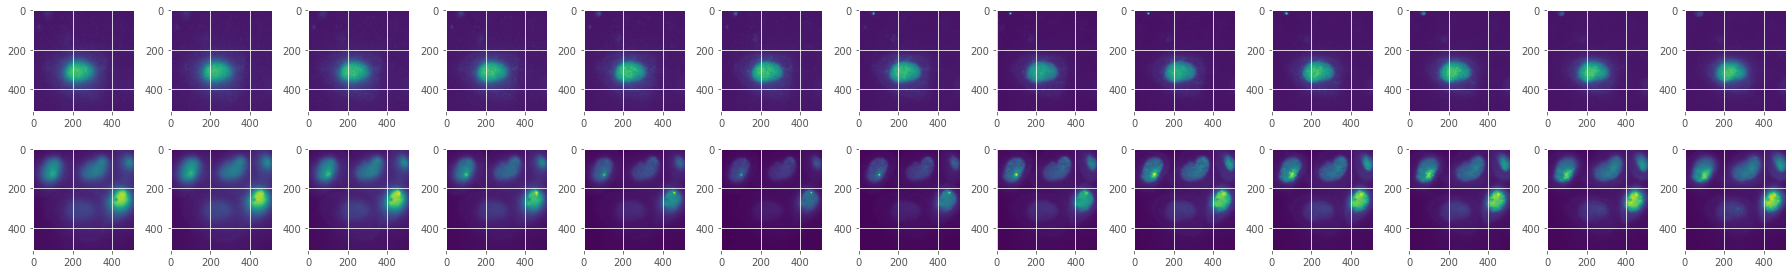

In [38]:
# Using big-fish to detect the spots in single time point.

selected_time =0
new_arr_time_point = new_arr[selected_time,:,:,:,:]
num_z = new_arr_time_point.shape[0]
num_colors = new_arr_time_point.shape[-1]
selected_color_channel = 1

print(new_arr_time_point.shape)
# Plotting
_, axes = plt.subplots(nrows = num_colors, ncols = num_z , figsize = (25, 4))
for i in range (num_colors):
    for j in range (num_z):
        temp_img = fa.RemoveExtrema(new_arr_time_point[j,:,:,i], min_percentile = 0.01, max_percentile = 99.99).remove_outliers()
        axes[i,j].imshow(temp_img)
        #axes[i,j].grid(False); axes[i,j].set_xticks([]); axes[i,j].set_yticks([])
plt.tight_layout()    
plt.show()

In [ ]:
raise

In [ ]:
# print('image shape:',list_images[0].shape )
# num_z = list_images[0].shape[0]
# selected_color_channel = 0
# _, axes = plt.subplots(nrows = 1, ncols = num_z, figsize = (30, 5))
# for i in range (num_z):
#     simulated_image_removed_extreme_values = fa.RemoveExtrema(list_images[0][i,:,:,selected_color_channel],min_percentile=0, max_percentile=99.9).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
#     axes[i].imshow( simulated_image_removed_extreme_values ) #list_images[0][i,:,:,selected_color_channel])
#     axes[i].grid(False); axes[i].set_xticks([]); axes[i].set_yticks([])
    
# 0= spots
# 1= GAPDH
# 2 = DAPI


In [ ]:
# print('image shape:',list_images[0].shape )
# num_z = 3 #list_images[0].shape[0]
# start_z=10
# selected_color_channel = 0
# _, axes = plt.subplots(nrows = 1, ncols = num_z, figsize = (30, 15))
# for i in range (0,num_z):
#     simulated_image_removed_extreme_values = fa.RemoveExtrema(list_images[0][i+num_z+start_z,:,:,selected_color_channel],min_percentile=0, max_percentile=99.5).remove_outliers()  #np.max(simulated_image[:,:,:,i],axis = 0)
#     axes[i].imshow( simulated_image_removed_extreme_values ) #list_images[0][i,:,:,selected_color_channel])
#     axes[i].grid(False); axes[i].set_xticks([]); axes[i].set_yticks([])

## Running the pipeline

----

In [39]:
dataframe_FISH,_,_,_,output_identification_string = fa.PipelineFISH(image = new_arr_time_point,
                                                                    channels_with_cytosol=channels_with_cytosol, 
                                                                    channels_with_nucleus=channels_with_nucleus, 
                                                                    channels_with_FISH=channels_with_FISH,
                                                                    diameter_nucleus=diameter_nucleus, 
                                                                    diameter_cytosol=diameter_cytosol,
                                                                    minimum_spots_cluster=minimum_spots_cluster, 
                                                                    masks_dir=masks_dir,  
                                                                    voxel_size_z=voxel_size_z,
                                                                    voxel_size_yx=voxel_size_yx ,psf_z=psf_z,psf_yx=psf_yx, show_plots=show_plots,  
                                                                    file_name_str=data_folder_path.name, 
                                                                    optimization_segmentation_method=optimization_segmentation_method,
                                                                    save_all_images=save_all_images,
                                                                    threshold_for_spot_detection=threshold_for_spot_detection,
                                                                    save_filtered_images=save_filtered_images,
                                                                    number_of_images_to_process=number_of_images_to_process,
                                                                    remove_z_slices_borders=remove_z_slices_borders,
                                                                    save_pdf_report=save_pdf_report,
                                                                    display_spots_on_multiple_z_planes=display_spots_on_multiple_z_planes,
                                                                    model_nuc_segmentation='nuclei', # ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4']
                                                                    model_cyto_segmentation='cyto', # ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4']
                                                                    pretrained_model_nuc_segmentation=None, #nuclei_model_path,
                                                                    remove_out_of_focus_images=remove_out_of_focus_images,
                                                                    pretrained_model_cyto_segmentation=cyto_model_path ).run()


 Output folder name :  temp___nuc_100__cyto_100__psfz_200__psfyx_160__ts_None

 ###################### 
        IMAGE : 0
 ###################### 
    Image Name :   temp.tif
    Original Image Shape :                    [13, 512, 512, 2]
    Image sharpness metric :                  1.137
    Number of detected cells:                 7
Error during the log filter calculation, try using larger parameters values for the psf
not showing elbow plot


TypeError: 'NoneType' object is not subscriptable

## Extracting data from the dataframe

----

In [ ]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.head()


In [ ]:
print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_int_ch_0','pseudo_cyto_int_ch_0','complete_cell_int_ch_0' ,'cyto_int_ch_0']]  )

In [ ]:
print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_int_ch_1','pseudo_cyto_int_ch_1' ,'complete_cell_int_ch_1','cyto_int_ch_1']]  )

In [ ]:
#print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_int_ch_2','pseudo_cyto_int_ch_2' ,'complete_cell_int_ch_2','cyto_int_ch_2']]  )

In [ ]:
#print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_cyto_int_ratio_ch_0','nuc_cyto_int_ratio_ch_1' ,'nuc_cyto_int_ratio_ch_2']]  )

In [ ]:
#print(dataframe_FISH.loc[ (dataframe_FISH['cell_id'] >= 0) & (dataframe_FISH['spot_id'] == 0), ['nuc_pseudo_cyto_int_ratio_ch_0','nuc_pseudo_cyto_int_ratio_ch_1' ,'nuc_pseudo_cyto_int_ratio_ch_2']]  )

## Plots

In [ ]:
list_files_distributions = fa.Plots().plot_all_distributions(dataframe_FISH,channels_with_cytosol, channels_with_nucleus,channels_with_FISH,minimum_spots_cluster,output_identification_string )

In [ ]:
file_plots_bleed_thru = fa.Plots().plot_scatter_bleed_thru(dataframe_FISH, channels_with_cytosol, channels_with_nucleus,output_identification_string)

In [ ]:
# plots for cytosol nucleus intensity ratios
if not fa.Utilities().is_None(channels_with_cytosol):
    file_plots_int_ratio = fa.Plots().plot_nuc_cyto_int_ratio_distributions(dataframe_FISH,output_identification_string=None,plot_for_pseudo_cytosol=False)
else:
    file_plots_int_ratio = None
file_plots_int_pseudo_ratio = fa.Plots().plot_nuc_cyto_int_ratio_distributions(dataframe_FISH,output_identification_string=None,plot_for_pseudo_cytosol=True)


## Saving data

In [ ]:
# Saving data and plots, and sending data to NAS
fa.Utilities().save_output_to_folder(output_identification_string, data_folder_path, 
                                   list_files_distributions=list_files_distributions,
                                   file_plots_bleed_thru=file_plots_bleed_thru,
                                   file_plots_int_ratio=file_plots_int_ratio,
                                   file_plots_int_pseudo_ratio=file_plots_int_pseudo_ratio,
                                   channels_with_FISH=channels_with_FISH,save_pdf_report=save_pdf_report)

# sending data to NAS
analysis_folder_name, mask_dir_complete_name = fa.Utilities().sending_data_to_NAS(output_identification_string, data_folder_path, path_to_config_file, path_to_masks_dir, diameter_nucleus, diameter_cytosol, send_data_to_NAS, masks_dir)

# Moving the complete analysis folder to final analyses folder 
fa.Utilities().move_results_to_analyses_folder( output_identification_string, data_folder_path, mask_dir_complete_name, path_to_masks_dir, save_filtered_images, download_data_from_NAS )

In [ ]:
# Extracting TS intensity. for all cells

number_cells = dataframe_FISH['cell_id'].nunique()
minimum_spots_cluster = 2
ts_size =  dataframe_FISH.loc[ (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True) &  (dataframe_FISH['cluster_size']>=minimum_spots_cluster)  & (dataframe_FISH['is_cell_fragmented']!=-1)   ].cluster_size.values

ts_size

In [ ]:
#list_ts = sorted(dataframe.loc[ (dataframe['cell_id']==df_index) & (dataframe['is_cluster']==True) &   (dataframe['cluster_size']>=minimum_spots_cluster)  ].cluster_size.values, reverse=True)
#min_length = min(len(ts_array), len(list_ts))
#ts_array[:min_length] = list_ts[:min_length]
# Size of the nucleus of each cell
#nuc_area = dataframe.loc[   (dataframe['cell_id']==df_index) ].nuc_area_px.values[0]   